# Binomial parameter
## 1. Prelude
### 1.1
#### Mean

$$E(n) = \sum_{n=0}^N n \begin{pmatrix}N\\n\end{pmatrix} p^n (1-p)^{N-n}$$
$$E(n) = \sum_{n=1}^N n \frac{N!}{n! (N-n)!} p^n (1-p)^{N-n}$$
$$E(n) = \sum_{n=1}^N \frac{N!}{(n-1)! (N-n)!} p^n (1-p)^{N-n}$$
$$E(n) = pN \sum_{n=1}^N \frac{(N-1)!}{(n-1)! (N-n)!} p^{n-1} (1-p)^{N-n}$$
$$E(n) = pN \sum_{k=0}^{N-1} \frac{(N-1)!}{k! (N-1-k)!} p^k (1-p)^{N-1-k}$$
$$E(n) = pN$$

#### Variance
The variance for a single random variable for which $x=1$ with probability $p$, and $x=0$ with probability $1-p$, (special case for $N=1$: Bernouilli variable), is:

$$V(x) = E(x^2) - E(x)^2 = p - p^2 = p (1-p)$$

The binominal distribution corresponds to the probability for a sum of $N$ independent such Bernouilli variables. The variance of the sum is the sum of the variances:

$$V(n) = N p (1-p)$$

### 1.2 MLE
$$\frac{\partial \ln \mathcal{L}}{\partial p} = \frac{n}{p} - \frac{N-n}{1-p} $$

$$\hat{p}_{\textrm{MLE}} = \frac{n}{N}$$

From the variance of $n$, it follows that

$$V(\hat{p}_{\textrm{MLE}}) = \frac{p(1-p)}{N}$$

### 1.4 Draw the distribution

In [11]:
import scipy
import scipy.special
import numpy as np
import matplotlib.pyplot as plt

In [12]:
def binomial(n,N,p):
    return scipy.special.binom(N,n) * (p**n) * ((1-p)**(N-n))

def mle(n,N):
    return n/N

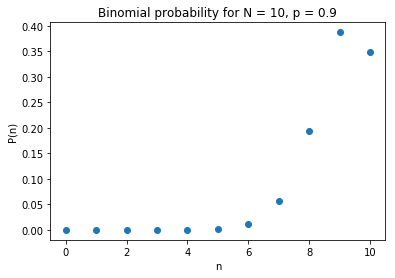

In [13]:
N=10
p=0.9

n = np.arange(0,11,1)
prob = binomial(n, N, p)

fig, ax = plt.subplots()
ax.plot(n, prob, 'o')
ax.set_xlabel('n')
ax.set_ylabel('P(n)')
ax.set_title('Binomial probability for N = {}, p = {}'.format(N, p))
plt.show()

### 1.3 Simple algorithm for generating a binomial random variable

In [4]:
def random_binomial(N,p):
    sum = 0
    for i in range(N):
        rnd = np.random.random()
        if (rnd<p):
            sum = sum + 1
    return sum

## 2. Interval estimation

In [5]:
from scipy.special import erfinv

def Zalpha(alpha):
    return np.sqrt(2)*erfinv(1-alpha)

In [6]:
def Wald(n,N,alpha):
    phat = mle(n,N)
    var = phat*(1-phat)/N
    low = phat - Zalpha(alpha)*np.sqrt(var)
    high = phat + Zalpha(alpha)*np.sqrt(var)
    return [low,high]

In [7]:
def Wilson(n,N,alpha):
    phat = mle(n,N)
    T = Zalpha(alpha)**2 / N
    ptilde = (phat + T/2) / (1 + T)
    low = ptilde - np.sqrt(phat*(1-phat)*T + T*T/4) / (1+T)
    high = ptilde + np.sqrt(phat*(1-phat)*T + T*T/4) / (1+T)
    return [low,high]

In [8]:
def AgrestiCoull(n,N,alpha):
    phat = mle(n,N)
    T = Zalpha(alpha)**2 / N
    ptilde = (phat + T/2) / (1 + T)
    var = ptilde*(1-ptilde)/N
    low = ptilde - Zalpha(alpha)*np.sqrt(var)
    high = ptilde + Zalpha(alpha)*np.sqrt(var)
    return [low,high]

In [9]:
# Neyman construction for Clopper-Pearson

def binomial_cdf(n,N,p):
    sum = 0
    for i in range(n+1):
        sum = sum + binomial(i,N,p)
    return sum

def binomial_cdfc(n,N,p):
    sum = 0
    for i in range(n,N+1):
        sum = sum + binomial(i,N,p)
    return sum

def neyman_low_p(N,p,a):
    ans = []
    for i in range(N+1):
        cdf = binomial_cdf(i,N,p)
        if (cdf<=a/2.):
            ans.append(0)
        else:
            ans.append(1)
    return ans

def neyman_high_p(N,p,a):
    ans = []
    for i in range(N+1):
        cdfc = binomial_cdfc(i,N,p)
        if (cdfc<=a/2.):
            ans.append(0)
        else:
            ans.append(1)
    return ans

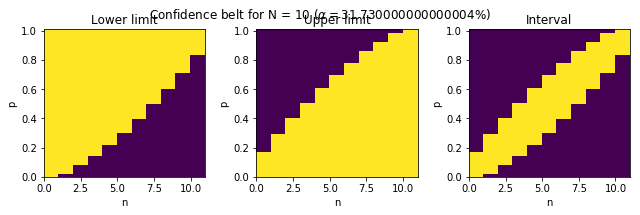

In [10]:
alpha = 1-0.6827
N = 10

# we will store the confidence belts as dictionaries
histBeltl = {}
histBelth = {}
histBelt = {}

# this array goes up to N+1 included, for plotting purposes
ns = np.arange(0, N+2, 1)
ps = np.linspace(0, 1.01, 100) 

for p in ps:
    if p > 1:
        break
    lowb = neyman_low_p(N,p,alpha)
    highb = neyman_high_p(N,p,alpha)
    for n in ns:
        if n > N:
            break
        histBeltl[(n, p)] = highb[n]
        histBelth[(n, p)] = lowb[n]
        histBelt[(n, p)] = lowb[n]*highb[n]

# convert the dictionaries into 2D numpy arrays
def dict_to_array_2D(d, array_x, array_y):
    ans = []
    for y in array_y[:-1]: # skip the last element (required by pcolormesh)
        line = []
        for x in array_x[:-1]: # skip the last element (required by pcolormesh)
            if (x,y) in d:
                line.append(d[(x,y)])
            else:
                line.append(0)
        ans.append(line)
    return np.array(ans)
        
histBeltl = dict_to_array_2D(histBeltl, ns, ps)
histBelth = dict_to_array_2D(histBelth, ns, ps)
histBelt = dict_to_array_2D(histBelt, ns, ps)
    
plt.figure(figsize=(9, 3))
plt.subplot(131)
plt.pcolormesh(ns, ps, histBeltl)
plt.xlabel('n')
plt.ylabel('p')
plt.title('Lower limit')
plt.subplot(132)
plt.pcolormesh(ns, ps, histBelth)
plt.xlabel('n')
plt.ylabel('p')
plt.title('Upper limit')
plt.subplot(133)
plt.pcolormesh(ns, ps, histBelt)
plt.xlabel('n')
plt.ylabel('p')
plt.title('Interval')
plt.suptitle(r'Confidence belt for N = {} ($\alpha = {}$%)'.format(N, alpha*100))
plt.tight_layout()
plt.show()

Comment: it is clear here the difference between the horizontal and vertical axes in Neyman construction, which are of very different nature in this case. The horizontal axis, n (the data), is discrete and takes values between 0 and N. The vertical axis, p (the parameter), is continuous and takes values between 0 and 1. When reading it vertically, we do not care about the left or right "edge" of the band at the observed value of n, but we take the corresponding "column", or "vertical slice", as a whole.

In [15]:
# a global variable holding the belts, to speed up things
# we don't want to re-compute the belt at each function call
belts = {}

def ClopperPearson(n,N,alpha):
    # use the same binning in p in all cases
    ps = np.linspace(0, 1, 101) 
    
    # first step: build the confidence belt    
    # if it does not exist: create it
    if not (n, N, alpha) in belts:
        belt = {}
        ns = np.arange(0, N+1, 1)
        for p in ps:
            lowb = neyman_low_p(N,p,alpha)
            highb = neyman_high_p(N,p,alpha)
            for n2 in ns:
                belt[(n2, p)] = lowb[n2]*highb[n2]
        belts[(n, N, alpha)] = belt
    
    # now we have the confidence belt
    belt = belts[(n, N, alpha)]
    
    # read the confidence interval off the confidence belt
    low = 0
    high = 1
    lowok = False
    highok = False
    for p in ps:
        bc = belt[(n, p)] if (n, p) in belt else 0

        # first check the lower bound of the interval
        if not lowok:
            if bc>0:
                low = p
                lowok = True
        # then check the upper bound
        elif not highok:
            if bc==0:
                high = p
                highok = True

        # finally if we have both the lower and upper bounds: break
        if lowok and highok:
            break
    
    # return the result
    return [low,high]

# analytic expression for Clopper-Pearson (much faster; as implemented in ROOT)
# https://root.cern.ch/doc/master/TEfficiency_8cxx_source.html#l01814
from scipy.stats import beta
def ROOT_TEfficiency_ClopperPearson(total, passed, level, upper):
    alpha = (1.0 - level) / 2
    if upper:
        return 1.0 if passed == total else beta.ppf(1 - alpha,passed + 1,total-passed)
    else:
        return 0.0 if passed == 0 else beta.ppf(alpha,passed,total-passed+1.0)
    
def ClopperPearson2(n,N,alpha):
    return [ROOT_TEfficiency_ClopperPearson(N,n,1-alpha,False),ROOT_TEfficiency_ClopperPearson(N,n,1-alpha,True)]

### 2.1 Specific cases

In [20]:
alpha = 1-0.68
# case 1
N=10
n=9
print("N=",N, ", n=", n)
print("Wald:", Wald(n,N,alpha))
print("Wilson:", Wilson(n,N,alpha))
print("Agresti-Coull:", AgrestiCoull(n,N,alpha))
print("Clopper-Pearson:", ClopperPearson(n,N,alpha))
print("Clopper-Pearson:", ClopperPearson2(n,N,alpha))

N= 10 , n= 9
Wald: [0.8056574415584239, 0.9943425584415762]
Wilson: [0.7670724437510268, 0.9609318297691034]
Agresti-Coull: [0.7562043496825109, 0.9717999238376193]
Clopper-Pearson: [0.71, 0.99]
Clopper-Pearson: [0.706686217751758, 0.9827157772761715]


In [21]:
# case 2
N=10
n=5
print("N=",N, ", n=", n)
print("Wald:", Wald(n,N,alpha))
print("Wilson:", Wilson(n,N,alpha))
print("Agresti-Coull:", AgrestiCoull(n,N,alpha))
print("Clopper-Pearson:", ClopperPearson(n,N,alpha))
print("Clopper-Pearson:", ClopperPearson2(n,N,alpha))

N= 10 , n= 5
Wald: [0.3427624025973731, 0.6572375974026269]
Wilson: [0.3500044516495263, 0.6499955483504737]
Agresti-Coull: [0.3427624025973731, 0.6572375974026269]
Clopper-Pearson: [0.31, 0.7000000000000001]
Clopper-Pearson: [0.3055775768233088, 0.6944224231766912]


In [22]:
# case 3
N=100
n=90
print("N=",N, ", n=", n)
print("Wald:", Wald(n,N,alpha))
print("Wilson:", Wilson(n,N,alpha))
print("Agresti-Coull:", AgrestiCoull(n,N,alpha))
print("Clopper-Pearson:", ClopperPearson(n,N,alpha))
print("Clopper-Pearson:", ClopperPearson2(n,N,alpha))

N= 100 , n= 90
Wald: [0.8701662635037074, 0.9298337364962926]
Wilson: [0.8661383500480521, 0.9260275531250489]
Agresti-Coull: [0.8657367803850864, 0.9264291227880146]
Clopper-Pearson: [0.87, 0.9400000000000001]
Clopper-Pearson: [0.8605958000948069, 0.9301990625941426]


In [23]:
# case 4
N=10
n=10
print("N=",N, ", n=", n)
print("Wald:", Wald(n,N,alpha))
print("Wilson:", Wilson(n,N,alpha))
print("Agresti-Coull:", AgrestiCoull(n,N,alpha))
print("Clopper-Pearson:", ClopperPearson(n,N,alpha))
print("Clopper-Pearson:", ClopperPearson2(n,N,alpha))

N= 10 , n= 10
Wald: [1.0, 1.0]
Wilson: [0.9100053419001627, 0.9999999999999999]
Agresti-Coull: [0.8898125096247866, 1.020192832275376]
Clopper-Pearson: [0.84, 1]
Clopper-Pearson: [0.8325532074018731, 1.0]


#### Comments
* Wald intervals tend to be smaller, while Clopper-Pearson ones tend to be larger.
* For large N, they all are quite similar, but they give very different results for small N.
* Things can get a little problematic when we go close to the boundary. In particular, for n=N=10, Wald returns an empty interval! Besides, in this case, the upper limit of the Agresti-Coull interval goes above 1...
* The analytic version of Clopper-Pearson matches well the implementation using Neyman construction.

## 3. Coverage
### Coverage for N=10, p=0.5

In [16]:
# parameters
Ntoys=1000
N=10
p=0.5
alpha = 1-0.68

def coverage_onep(N, p, alpha, Ntoys, interval_function):
    """
    Compute the coverage using toys, for a given N and p
    """
    arr = []
    for i in range(0,Ntoys):
        ntoy = random_binomial(N,p)
        phat = mle(ntoy,N)
        interval = interval_function(ntoy,N,alpha)
        arr.append(int(p>=interval[0] and p<=interval[1]))
    return (np.mean(arr))

In [29]:
print("coverage (N = ", N, ", p = ", p, ", 1-alpha = ", 1-alpha, "):")
print("Wald:", coverage_onep(N, p, alpha, Ntoys, Wald))
print("Wilson:", coverage_onep(N, p, alpha, Ntoys, Wilson))
print("Agresti-Coull:", coverage_onep(N, p, alpha, Ntoys, AgrestiCoull))
print("Clopper-Pearson:", coverage_onep(N, p, alpha, Ntoys, ClopperPearson))
print("Clopper-Pearson (analytic):", coverage_onep(N, p, alpha, Ntoys, ClopperPearson2))

coverage (N =  20 , p =  0.5 , 1-alpha =  0.68 ):
Wald: 0.748
Wilson: 0.754
Agresti-Coull: 0.711
Clopper-Pearson: 0.745
Clopper-Pearson (analytic): 0.731


Comment: in this particular case ("easy" because N is relatively large and p is not close to the boundaries, 0 and 1), all four methods have decent coverage. They even all slightly over-cover.

### 3.1 Coverage as a function of p, for N=10

In [18]:
# define the values of p that we will be testing
array_p = np.linspace(0,1,101)

Ntoys = 1000

def coverage(N, alpha, Ntoys, interval_function):
    """
    Returns an array with the values of coverage for values of p in array_p
    """
    ans = []
    for p in array_p:
        ans.append(coverage_onep(N, p, alpha, Ntoys, interval_function))
    return ans

In [19]:
# compute the coverage for the different methods
array_Wald = coverage(N, alpha, Ntoys, Wald)
array_Wilson = coverage(N, alpha, Ntoys, Wilson)
array_AC = coverage(N, alpha, Ntoys, AgrestiCoull)
array_CP = coverage(N, alpha, Ntoys, ClopperPearson2)

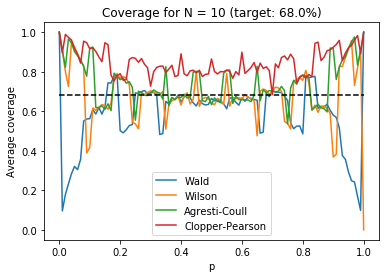

In [20]:
# plotting
fig, ax = plt.subplots()
ax.plot(array_p, array_Wald, label='Wald')
ax.plot(array_p, array_Wilson, label='Wilson')
ax.plot(array_p, array_AC, label='Agresti-Coull')
ax.plot(array_p, array_CP, label='Clopper-Pearson')
ax.plot([0,1],[1-alpha,1-alpha],'--',color='black')
ax.set_xlabel('p')
ax.set_ylabel('Average coverage')
ax.set_title('Coverage for N = {} (target: {}%)'.format(N, (1-alpha)*100))
ax.legend(loc='lower center')
plt.show()

Comments: 
* The coverage is found to be symmetric around p=0.5 (not surprisingly: this symmetry is there in the definition of the binomial law). 
* The worst deviations from coverage (especially for Wald) are found close to 0 and 1. Wald can badly under-cover in these regions, with coverage as bad as 10% (for a target 68%)! 
* On the other hand, there is always over-coverage for the Clopper-Pearson intervals (by definition since they are built using Neyman construction), but this over-coverage can be very large, especially again close to 0 or 1. 
* Wilson and Agresti-Coull are kind of in between, alternating between under- and over-coverage depending on the true value of p. Agresti-Coull under-covers in fewer cases, and never too badly.

### 3.2 Coverage as a function of p and N (2D)

In [21]:
# now vary N too
# we will store the coverage values into 2D arrays (arrays of arrays)
array2_Wald = []
array2_Wilson = []
array2_AC = []
array2_CP = []

array_N = np.arange(2,21)
for N in array_N:
    array2_Wald.append(coverage(N, alpha, Ntoys, Wald))
    array2_Wilson.append(coverage(N, alpha, Ntoys, Wilson))
    array2_AC.append(coverage(N, alpha, Ntoys, AgrestiCoull))
    array2_CP.append(coverage(N, alpha, Ntoys, ClopperPearson2))

In [22]:
# some code to build a fancy color palette:
# shades of red for the under-coverage region, shades of green for over-coverage
from matplotlib import cm
from matplotlib.colors import ListedColormap
alpha100 = int(alpha*100)
top = cm.get_cmap('Reds', 100-alpha100)
bottom = cm.get_cmap('Greens', alpha100)
newcolors = np.vstack((top(np.linspace(0, 1-alpha, 100-alpha100)),
                       bottom(np.linspace(1-alpha, 1, alpha100))))
newcmp = ListedColormap(newcolors, name='OrangeBlue')
from matplotlib.colors import BoundaryNorm
#cmap = plt.get_cmap('hot')
norm = BoundaryNorm(np.linspace(0,1,100), ncolors=newcmp.N, clip=True)

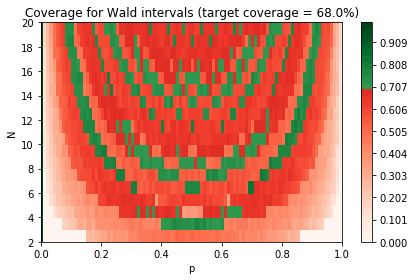

In [23]:
# plotting: Wald
fig, ax = plt.subplots()
im = ax.pcolormesh(array_p, array_N, array2_Wald, cmap=newcmp, norm=norm)
ax.set_xlabel('p')
ax.set_ylabel('N')
ax.set_title('Coverage for Wald intervals (target coverage = {}%)'.format((1-alpha)*100))
fig.colorbar(im)
plt.tight_layout()
plt.show()

Comment: we see a lot of red here! This mean that Wald intervals under-cover for most N and p, except for some magic combinations. The situation is especially bad for small N, or p close to 0 or 1.

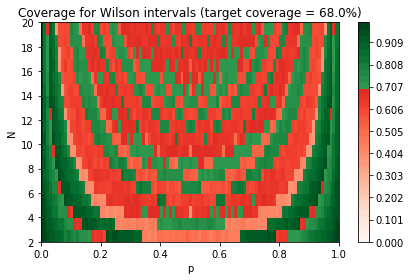

In [24]:
# plotting: Wilson
fig, ax = plt.subplots()
im = ax.pcolormesh(array_p, array_N, array2_Wilson, cmap=newcmp, norm=norm)
ax.set_xlabel('p')
ax.set_ylabel('N')
ax.set_title('Coverage for Wilson intervals (target coverage = {}%)'.format((1-alpha)*100))
fig.colorbar(im)
plt.tight_layout()
plt.show()

Comment: the situation is better for Wilson intervals than for Wald's, but there is still under-coverage in a lot of cases (though it is not as bad here).

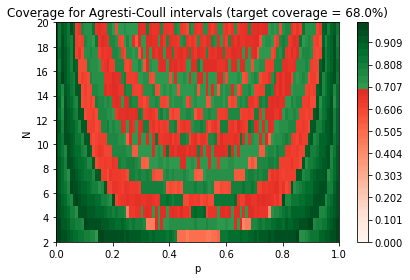

In [25]:
# plotting: Agresti-Coull
fig, ax = plt.subplots()
im = ax.pcolormesh(array_p, array_N, array2_AC, cmap=newcmp, norm=norm)
ax.set_xlabel('p')
ax.set_ylabel('N')
ax.set_title('Coverage for Agresti-Coull intervals (target coverage = {}%)'.format((1-alpha)*100))
fig.colorbar(im)
plt.tight_layout()
plt.show()

Comment: the Agresti-Coull intervals over-cover most of the time, and when they under-cover, they don't do it too badly.

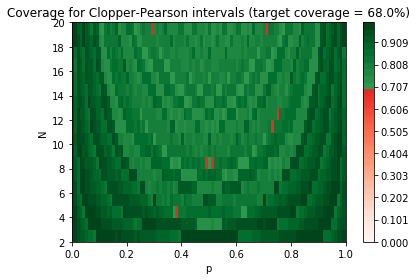

In [26]:
# plotting: Clopper-Pearson
fig, ax = plt.subplots()
im = ax.pcolormesh(array_p, array_N, array2_CP, cmap=newcmp, norm=norm)
ax.set_xlabel('p')
ax.set_ylabel('N')
ax.set_title('Coverage for Clopper-Pearson intervals (target coverage = {}%)'.format((1-alpha)*100))
fig.colorbar(im)
plt.tight_layout()
plt.show()

Comment: Clopper-Pearson intervals always cover by definition, since they are built using Neyman construction (except for some very rare cases, due to numerical effects). But this is at the cost of sometimes large over-coverage.

### 3.3 Coverage as a function of N, averaged over p

In [27]:
# average coverage as a function of N

arrayN_N = []
arrayN_Wald = []
arrayN_Wilson = []
arrayN_AC = []
arrayN_CP = []

for i in range(len(array_N)):
    arrayN_N.append(array_N[i])
    arrayN_Wald.append(np.mean(array2_Wald[i]))
    arrayN_Wilson.append(np.mean(array2_Wilson[i]))
    arrayN_AC.append(np.mean(array2_AC[i]))
    arrayN_CP.append(np.mean(array2_CP[i]))

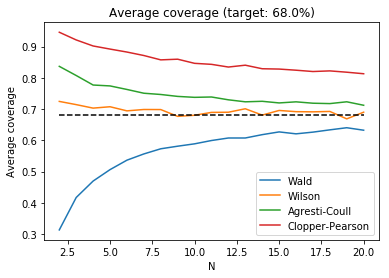

In [28]:
# plotting
fig, ax = plt.subplots()
ax.plot(array_N, arrayN_Wald, label='Wald')
ax.plot(array_N, arrayN_Wilson, label='Wilson')
ax.plot(array_N, arrayN_AC, label='Agresti-Coull')
ax.plot(array_N, arrayN_CP, label='Clopper-Pearson')
ax.plot([array_N[0], array_N[-1]], [1-alpha, 1-alpha], '--', color='black')
ax.set_xlabel('N')
ax.set_ylabel('Average coverage')
ax.set_title('Average coverage (target: {}%)'.format((1-alpha)*100))
ax.legend(loc='lower right')
plt.show()

Wald intervals under-cover on average, quite badly at small N. Wilson intervals feature correct coverage on average, meaning that they can be a good choice for graphical representation (e.g. error bars on an efficiency plot), if we do not expect a solid statistical interpretation from the intervals. Clopper-Pearson intervals very stronly over-cover, especially at small N. At large N, all intervals tend to get closer coverage to the target confidence level.